In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import seaborn as sns

In [2]:
def calculate_death_probability(age, gender, max_age=100):
    """
    Рассчитывает вероятность смерти за год на основе возраста и пола.
    
    :param age: Возраст человека.
    :param gender: Пол ("male" или "female").
    :param max_age: Максимальный возраст, после которого вероятность смерти равна 1.
    :return: Вероятность смерти за год (0.0–1.0).
    """
    if age < 1:
        return 0.005
    elif age < 15:
        return 0.0002
    elif age < 40:
        base_rate = 0.0003 if gender == "female" else 0.0004
        return base_rate + age * 0.00002
    elif age < 60:
        base_rate = 0.002 if gender == "female" else 0.003
        return base_rate + (age - 40) * 0.0001
    elif age < max_age:
        base_rate = 0.1 if gender == "female" else 0.15
        return min(1.0, base_rate + (age - 60) * 0.005)
    return 1.0


def calculate_birth_probability(age, fertile_age_range, number_of_children, max_children_number=4):
    """
    Прогнозирует вероятность рождения женщиной ребенка в течение года.

    :param age: int. Возраст женщины.
    :param fertile_age_range: tuple. Диапазон фертильного возраста, например (17, 50).
    :param number_of_children: int. Количество уже имеющихся детей.
    :return: float. Вероятность рождения ребенка в течение года.
    """
    min_fertile_age, max_fertile_age = fertile_age_range
    if age < min_fertile_age or age > max_fertile_age:
        return 0.0
    age_specific_fertility = {
        (min_fertile_age, 19): 0.10,  # 10% в год
        (20, 24): 0.18,               # 18% в год
        (25, 29): 0.20,               # 20% в год
        (30, 34): 0.15,               # 15% в год
        (35, 39): 0.10,               # 10% в год
        (40, 44): 0.05,               # 5% в год
        (45, max_fertile_age): 0.01,  # 1% в год
    }

    base_probability = 0.0
    for age_range, probability in age_specific_fertility.items():
        if age_range[0] <= age <= age_range[1]:
            base_probability = probability
            break

    children_penalty = 1.0 / max_children_number
    adjusted_probability = max(0.0, base_probability * (1 - children_penalty * number_of_children))
    
    return adjusted_probability


In [5]:
POPULATION_SETTINGS = {
    "fertile_age_range": {
        "female": (17, 50),
        "male": (12, 70)
    },
    "fertility_rate": 1.5,
    "initial_age_distribution": {
        (0, 14): 0.17,   # 17% детей
        (15, 24): 0.12,  # 12% подростков и молодых взрослых
        (25, 54): 0.40,  # 40% трудоспособного населения
        (55, 64): 0.13,  # 13% предпенсионного возраста
        (65, 79): 0.14,  # 14% пожилых людей (младшие пенсионеры)
        (80, 90): 0.04   # 4% старших пожилых людей
    },
    'initial_race_distribution': {
        "green": 0.50,
        "brown": 0.50
    },
    'gender_ratio_at_birth': {
        "male": 0.512,   # 51.2% новорожденных — мальчики
        "female": 0.488  # 48.8% новорожденных — девочки
    },
    'max_age': 90,
    'birth_probability': calculate_birth_probability,
    'death_probability': calculate_death_probability
}

POPULATION_INIT_SIZE = 10_000

In [7]:
class Human:
    def __init__(self, gender: str, genotype: str, age: int):
        self.gender = gender
        self.genotype = genotype
        self.age = age
        self.number_of_children = 0

    def die(self):
        del self

    def __repr__(self):
        self_repr = f'Human(gender={self.gender}, race={self.genotype}, age={self.age})'
        if self.gender == 'female' and self.number_of_children > 0:
            self_repr = f'{self_repr}, number of children: {self.number_of_children}'
        return self_repr


In [9]:
class Population:
    def __init__(self, population_settings):
        self.members = []
        self.population_settings = population_settings
        self.birth_probability = self.population_settings['birth_probability']
        self.death_probability = self.population_settings['death_probability']
        self.gender_ratio_at_birth = self.population_settings['gender_ratio_at_birth']
        self.female_fertile_age_range = self.population_settings['fertile_age_range']['female']
        self.male_fertile_age_range = self.population_settings['fertile_age_range']['male']
        self.genetic_components = set(self.population_settings['initial_race_distribution'].keys())
 
    def get_population_size(self):
        return len(self.members)

    def get_average_age(self):
        if not self.members:
            return 0
        total_age = sum(member.age for member in self.members)
        return total_age / len(self.members)

    def generate_population(self, size):
        age_distribution = self.population_settings['initial_age_distribution']
        genetic_distribution = self.population_settings['initial_race_distribution']
        gender_distribution = self.population_settings['gender_ratio_at_birth']
        
        for _ in range(size):
            # Select age group and random age
            age_group = random.choices(
                population=list(age_distribution.keys()),
                weights=list(age_distribution.values()),
                k=1
            )[0]
            age = random.randint(*age_group)
    
            # Select gender
            gender = random.choices(
                population=list(gender_distribution.keys()),
                weights=list(gender_distribution.values()),
                k=1
            )[0]
    
            # Select genetic component
            genetic_component = random.choices(
                population=list(genetic_distribution.keys()),
                weights=list(genetic_distribution.values()),
                k=1
            )[0]
            other_genetic_component = self.get_other_set_item(
                self.genetic_components, genetic_component
            )
            genotype = {genetic_component: 1.0, other_genetic_component: 0.0}
    
            # Add new human to the population
            self._add_human(Human(gender=gender, genotype=genotype, age=age))

    def evolve(self, years):
        for _ in range(years):
            self._simulate_year()

    def stat(self):
        """
        Возвращает статистику о популяции.
        :return: Словарь с ключами на английском языке.
        """
        if not self.members:
            return {
                'population_size': 0,
                'min_age': None,
                'max_age': None,
                'average_age': None,
                'gender_ratio': None,
            }
    
        ages = [human.age for human in self.members]
        male_count = sum(1 for human in self.members if human.gender == 'male')
        female_count = sum(1 for human in self.members if human.gender == 'female')

        return {
            "population_size": len(self.members),
            "min_age": min(ages),
            "max_age": max(ages),
            "average_age": sum(ages) / len(ages),
            "gender_ratio": {
                "male": male_count,
                "female": female_count,
                "ratio": male_count / female_count if female_count > 0 else 'N/A'
            },
        }

    def visualize(self):
        ages = [human.age for human in self.members]
        male_ages = [human.age for human in self.members if human.gender == "male"]
        female_ages = [human.age for human in self.members if human.gender == "female"]
    
        fig, axes = plt.subplots(3, 2, figsize=(14, 15))
    
        # Age Distribution
        axes[0, 0].hist(ages, bins=12, color="gray", alpha=0.8, label="All Ages")
        axes[0, 0].legend()
        axes[0, 0].set_title('Age Distribution')
        axes[0, 0].set_xlabel('Age (years)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
    
        # Age Distribution by Gender
        axes[0, 1].hist(
            [male_ages, female_ages],
            bins=12,
            label=["Men", "Women"],
            color=["blue", "pink"],
            alpha=0.8
        )
        axes[0, 1].legend()
        axes[0, 1].set_title('Age Distribution by Gender')
        axes[0, 1].set_xlabel('Age (years)')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
    
        # Stacked Bar Chart for Genetic Composition
        genetic_data = np.array(
            [[human.genotype.get("green", 0), human.genotype.get("brown", 0)] for human in self.members]
        ).T
    
        sort_order = np.argsort(genetic_data[0])[::-1]  # По убыванию компонента "green"
        genetic_data_sorted = genetic_data[:, sort_order]
    
        indices_sorted = np.arange(len(self.members))
    
        axes[1, 0].bar(indices_sorted, genetic_data_sorted[0], label="Green", color="green", alpha=0.7)
        axes[1, 0].bar(
            indices_sorted,
            genetic_data_sorted[1],
            bottom=genetic_data_sorted[0],
            label="Brown",
            color="brown",
            alpha=0.7
        )
        axes[1, 0].set_title('Genetic Composition (Stacked Bar)')
        axes[1, 0].set_xlabel('Individuals (sorted by % Green)')
        axes[1, 0].set_ylabel('Proportion')
        axes[1, 0].legend()
        axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
    
        # Box Plot for Genetic Distribution
        axes[1, 1].boxplot(
            [genetic_data[0], genetic_data[1]],
            tick_labels=["Green", "Brown"],
            patch_artist=True,
            boxprops=dict(facecolor="lightgreen", color="green"),
            medianprops=dict(color="red")
        )
        axes[1, 1].set_title('Genetic Composition (Box Plot)')
        axes[1, 1].set_ylabel('Proportion')
        axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)
    
        # Violin Plot for Genetic Distribution
        axes[2, 0].violinplot(genetic_data, showmedians=True)
        axes[2, 0].set_title('Genetic Composition (Violin Plot)')
        axes[2, 0].set_xticks([1, 2])
        axes[2, 0].set_xticklabels(["Green", "Brown"])
        axes[2, 0].set_ylabel('Proportion')
        axes[2, 0].grid(axis='y', linestyle='--', alpha=0.7)
    
        # Heatmap for Genetic Composition (matrix of green vs brown proportions)
        heatmap_data = np.array([[
            [green, brown] for green, brown in zip(genetic_data[0], genetic_data[1])
        ]])
    
        sns.heatmap(heatmap_data.reshape(-1, 2), annot=True, fmt='.2f', cmap="YlGnBu", ax=axes[2, 1])
        axes[2, 1].set_title('Genetic Composition (Heatmap)')
        axes[2, 1].set_xticklabels(["Green", "Brown"])
        axes[2, 1].set_yticklabels(np.arange(1, len(self.members) + 1))
    
        plt.tight_layout()
        plt.show()

    def _add_human(self, human):
        self.members.append(human)

    def _remove_human(self, human):
        self.members.remove(human)

    def _simulate_year(self):
        self.fertile_males = self._get_fertile_males()
    
        for human in list(self.members):
            human.age += 1
            self._simulate_death(human)
            self._simulate_birth(human)

    def _simulate_death(self, human):
        if random.random() < self.death_probability(
            human.age, human.gender, self.population_settings['max_age']):
            self._remove_human(human)
            del(human)

    def _simulate_birth(self, human):
        if human.gender == 'male':
            return
        if random.random() < self.birth_probability(
            human.age, self.female_fertile_age_range, human.number_of_children):

            father = random.choice(self.fertile_males)   # ПРОМИСКУИТЕТ какой-то позорный ;)

            new_gender = random.choices(
                population=list(self.gender_ratio_at_birth.keys()),
                weights=list(self.gender_ratio_at_birth.values()),
                k=1
            )[0]

            new_genotype = self._combine_genetics(
                human.genotype, father.genotype)

            human.number_of_children += 1

            self._add_human(Human(gender=new_gender, genotype=new_genotype, age=0))

    def _get_fertile_males(self):
        min_male_fertile_age_range, max_male_fertile_age_range = self.male_fertile_age_range
        fertile_males = [
            human for human in self.members
            if human.gender == 'male' and \
                (min_male_fertile_age_range <= human.age <= max_male_fertile_age_range)]
        return fertile_males
    
    def __repr__(self):
        return f"Population(size={self.get_population_size()})"

    @staticmethod
    def _combine_genetics(genotype_1, genotype_2):
        new_genotype = {}
        for genetic_component in genotype_1:
            new_genotype[genetic_component] = \
            (genotype_1[genetic_component] + genotype_2.get(genetic_component, 0)) / 2
        return new_genotype
        
    @staticmethod
    def get_other_set_item(set_, item):
        item_set = set()
        item_set.add(item)
        return (set_ - item_set ).pop()

In [11]:
POPULATION_INIT_SIZE = 100
population = Population(POPULATION_SETTINGS)
population.generate_population(POPULATION_INIT_SIZE)

ValueError: The number of FixedLocator locations (20), usually from a call to set_ticks, does not match the number of labels (100).

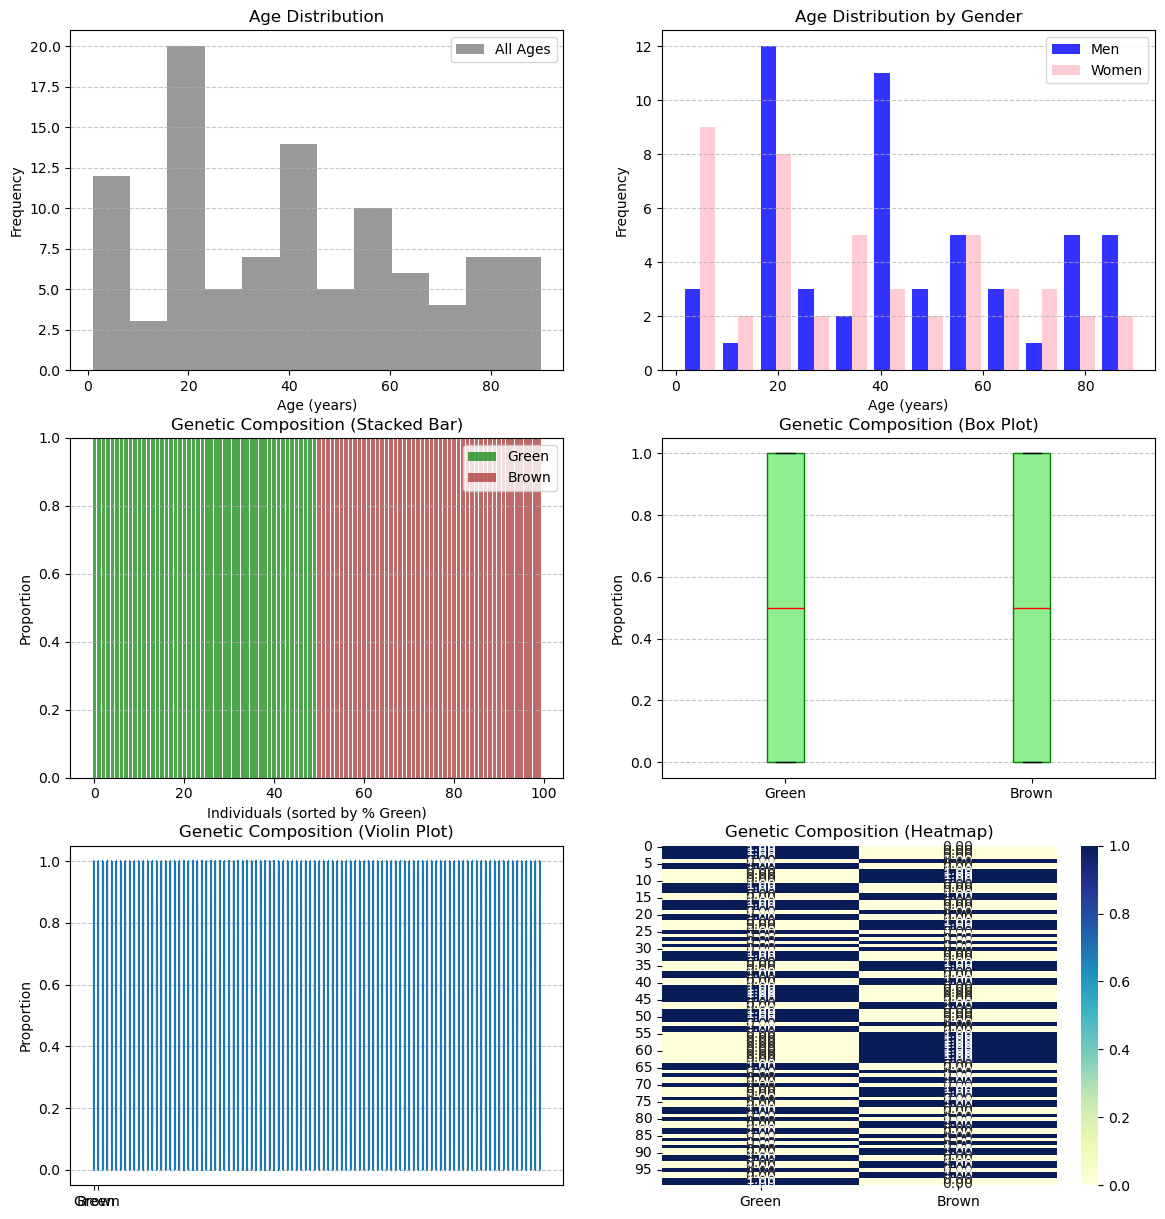

In [13]:
population.visualize()

In [15]:
population.stat()

{'population_size': 100,
 'min_age': 1,
 'max_age': 90,
 'average_age': 40.88,
 'gender_ratio': {'male': 54, 'female': 46, 'ratio': 1.173913043478261}}

In [17]:
population.evolve(200)

In [19]:
population.stat()

{'population_size': 480,
 'min_age': 0,
 'max_age': 76,
 'average_age': 29.302083333333332,
 'gender_ratio': {'male': 236, 'female': 244, 'ratio': 0.9672131147540983}}

ValueError: The number of FixedLocator locations (23), usually from a call to set_ticks, does not match the number of labels (480).

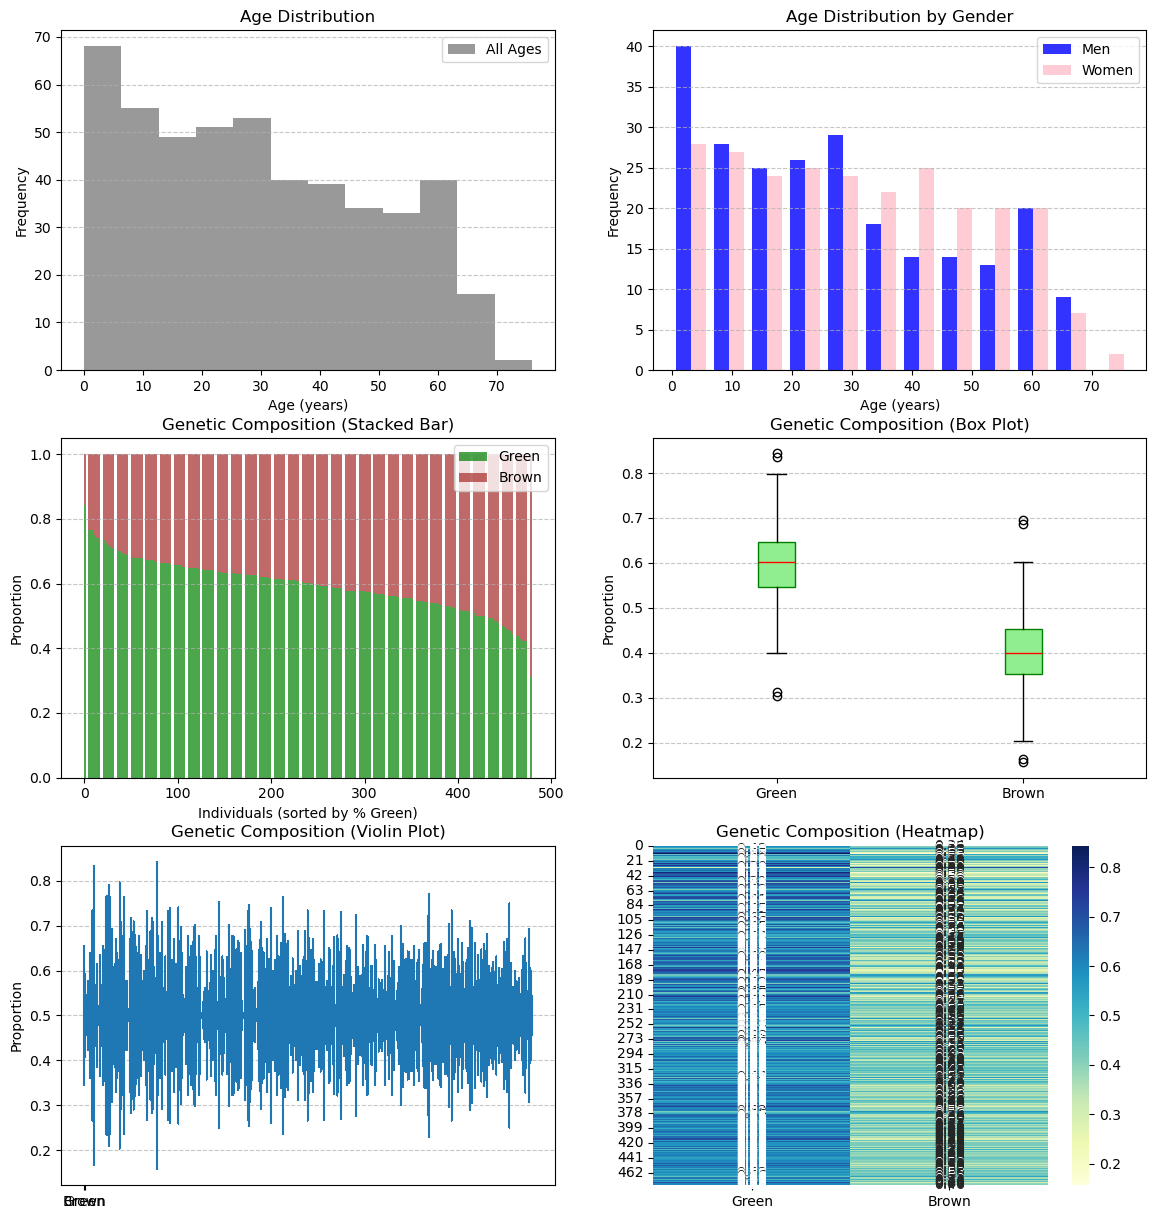

In [21]:
population.visualize()